# STEMMUS_SCOPE BMI groundwater coupling
We have to choose how we want to run the BMI. We can do this either using a local executable file, or with a Docker container.

How to run the model is define in the configuration file.
If it has an entry "ExeFilePath" it will use the local executable. If this is missing, it wil try to use Docker (if docker-py is available). 

In [1]:
cfg_file = "/home/bart/tmp/stemmus_scope/config_docker.txt"
#cfg_file = "/home/bart/tmp/stemmus_scope/config_exe.txt"

If we are using the local executable file we first have to add the matlab runtime compiler locations to PATH:

In [2]:
if "exe.txt" in cfg_file:
    from PyStemmusScope.config_io import read_config
    import os
    os.environ['LD_LIBRARY_PATH'] = (
        "/home/bart/matlab_runtime/R2023a/runtime/glnxa64:"
        "/home/bart/matlab_runtime/R2023a/bin/glnxa64:"
        "/home/bart/matlab_runtime/R2023a/sys/os/glnxa64:"
        "/home/bart/matlab_runtime/R2023a/extern/bin/glnxa64:"
        "/home/bart/matlab_runtime/R2023a/sys/opengl/lib/glnxa64"
    )
    os.environ["STEMMUS_SCOPE"] = read_config(cfg_file)["ExeFilePath"]

Now we can initialize the model with a prepared configuration file:

In [3]:
from PyStemmusScope.bmi.implementation import StemmusScopeBmi
from cftime import num2pydate
from rich import print
import numpy as np
import xarray as xr

model = StemmusScopeBmi()

model.initialize(cfg_file)

model.update()  # STEMMUS_SCOPE needs to be updated by one timestep before the BMI is accessible

After initialization we can enable the groundwater coupling. You enable this using the following command:

In [4]:
model.set_value("groundwater_coupling_enabled", np.array([True]))

To make use of the groundwater coupling routines, a few variables will need to be set:
- the elevation (above reference, e.g. Mean Sea Level) of the top of the aquifer (in cm)
- the groundwater head (above reference) in the lowest STEMMUS_SCOPE soil layer (in cm)

The groundwater height (where the hydrostatic pressure is equal to 0.0, will be at a depth of `groundwater_elevation_top_aquifer` - `groundwater_head_bottom_layer` in the STEMMUS_SCOPE model).

Lastly, a groundwater temperature can be defined. However, this is optional.

In [5]:
model.set_value("groundwater_elevation_top_aquifer", np.array([2000.]))
model.set_value("groundwater_head_bottom_layer", np.array([2000-250.]))  # 250 cm under ground surface

model.set_value("groundwater_temperature", np.array([50.])) # optional. 50 deg C here to get a high contrast

Now we can run the model. We define arrays to store the results that we want to inspect, and then step through all model timesteps:

In [6]:
n_timesteps = int((model.get_end_time() - model.get_current_time())/model.get_time_step())
n_soil_layers = model.get_grid_size(model.get_var_grid("soil_moisture"))

soil_moisture = np.zeros((n_timesteps, n_soil_layers))
soil_temperature = np.zeros((n_timesteps, n_soil_layers))
time = []
i=0

while model.get_current_time() < model.get_end_time():
    model.get_value("soil_moisture", soil_moisture[i])
    model.get_value("soil_temperature", soil_temperature[i])

    # Store the current time as a datetime
    time.append(num2pydate(model.get_current_time(), model.get_time_units()))

    i+=1
    model.update()


For easier anaylsis we can put the data into xarray DataArray objects:

In [7]:
gs = model.get_grid_size(1)
depths = np.ones(gs)
model.get_grid_z(1, depths)

da_sm = xr.DataArray(
    data=soil_moisture,
    dims=("time", "depth"),
    coords={"time": np.array(time), "depth": depths},
)

da_t = xr.DataArray(
    data=soil_temperature,
    dims=("time", "depth"),
    coords={"time": np.array(time), "depth": depths},
)

Now we can show the results. Note that up to ~2.5 m depth the soil is completely saturated, and that the temperature here equals the groundwater temperature we defined before.

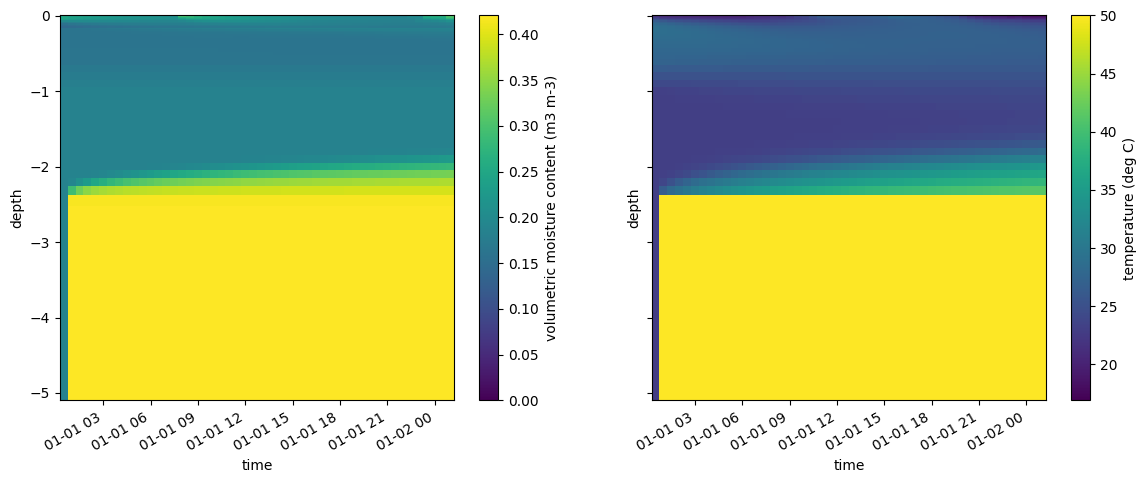

In [8]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(14,5))
ax1.set_title("Soil Moisture")
ax2.set_title("Soil Temperature")
ax1.set_ylabel("depth (m)")
ax2.set_ylabel("depth (m)")
da_sm.plot(y="depth", ax=ax1, cbar_kwargs={'label': "volumetric moisture content (m3 m-3)"})
da_t.plot(y="depth", ax=ax2, cbar_kwargs={'label': "temperature (deg C)"})

It is important to call `finalize()` on the model when you're done, otherwise the model will stay running in the background:

In [9]:
model.finalize()